In [18]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [19]:
# Load DNS and HTTP traffic data
dns_df = pd.read_csv('dns_traffic4.csv')
http_df = pd.read_csv('http_traffic4.csv')

In [20]:
# Convert 'Time' columns to datetime
dns_df['Time'] = pd.to_datetime(dns_df['Time'])
http_df['Time'] = pd.to_datetime(http_df['Time'])

In [21]:
# Identify relevant DNS traffic based on HTTP destinations
relevant_destinations = http_df['Destination'].unique()
dns_df = dns_df[dns_df['Destination'].isin(relevant_destinations)]

In [22]:
# Separate DNS queries and responses
dns_queries = dns_df[dns_df['Info'].str.contains("Standard query", case=False)]
dns_responses = dns_df[dns_df['Info'].str.contains("Standard query response", case=False)]

In [23]:
# Rename columns for clarity
dns_queries = dns_queries.rename(columns={'Time': 'Time_query'})
dns_responses = dns_responses.rename(columns={'Time': 'Time_response'})

In [24]:
# Pair DNS queries with responses based on Source, Destination, and Time proximity
dns_pairs = pd.merge_asof(
    dns_queries.sort_values('Time_query'), 
    dns_responses.sort_values('Time_response'), 
    left_on='Time_query', 
    right_on='Time_response', 
    by=['Source', 'Destination'],
    suffixes=('_query', '_response'),
    direction='forward'
)

# Calculate DNS resolution time
dns_pairs['Time_query'] = pd.to_datetime(dns_pairs['Time_query'])
dns_pairs['Time_response'] = pd.to_datetime(dns_pairs['Time_response'])
dns_pairs['resolution_time'] = (dns_pairs['Time_response'] - dns_pairs['Time_query']).dt.total_seconds()

In [25]:
# Filter HTTP requests
http_requests = http_df[http_df['Protocol'] == 'HTTP'].copy()

# Baseline Dependency Calculation (Unoptimized - not using the latest DNS response)
dependencies = []

In [26]:
for _, http_row in http_requests.iterrows():
    destination = http_row['Destination']
    
    # Find any DNS response for the destination prior to the HTTP request time
    dns_response = dns_pairs[(dns_pairs['Destination'] == destination) & 
                             (dns_pairs['Time_response'] < http_row['Time'])].head(1)  # Use the first (not necessarily latest) response
    
    if not dns_response.empty:
        dependency_time = (http_row['Time'] - dns_response['Time_response'].values[0]).total_seconds()
    else:
        dependency_time = None  # No matching DNS response found
    
    dependencies.append(dependency_time)

# Store the original dependencies in the DataFrame
http_requests['dns_http_dependency'] = dependencies

In [27]:
# Optimized Dependency Calculation (using latest DNS response)
optimized_dependencies = []
latest_dns_cache = {}  # To cache the latest DNS response time for each destination

In [28]:
for _, http_row in http_requests.iterrows():
    destination = http_row['Destination']
    
    # Check if we already have a cached DNS response for this destination
    if destination in latest_dns_cache and latest_dns_cache[destination] < http_row['Time']:
        # Use the cached response time if it's recent enough
        dependency_time = (http_row['Time'] - latest_dns_cache[destination]).total_seconds()
    else:
        # Find the latest DNS response before the HTTP request time
        dns_response = dns_pairs[(dns_pairs['Destination'] == destination) & 
                                 (dns_pairs['Time_response'] < http_row['Time'])].tail(1)  # Get the latest response
        
        if not dns_response.empty:
            dependency_time = (http_row['Time'] - dns_response['Time_response'].values[0]).total_seconds()
            # Cache this latest response time
            latest_dns_cache[destination] = dns_response['Time_response'].values[0]
        else:
            dependency_time = None
    
    optimized_dependencies.append(dependency_time)

# Store the optimized dependencies in the DataFrame
http_requests['dns_http_dependency_optimized'] = optimized_dependencies

### **Visualization**

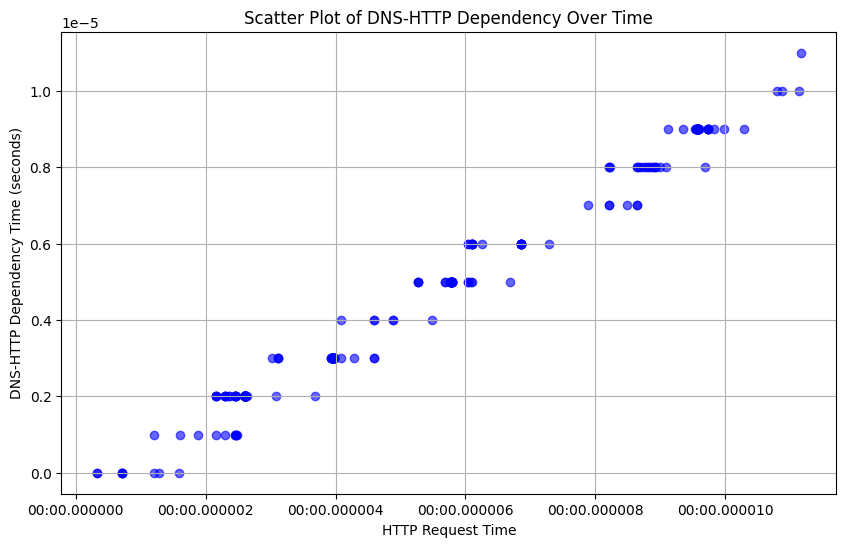

In [29]:
# Visualization 1: Scatter Plot of DNS-HTTP Dependency Times
plt.figure(figsize=(10, 6))
plt.scatter(http_requests['Time'], http_requests['dns_http_dependency'], alpha=0.6, color='blue')
plt.xlabel('HTTP Request Time')
plt.ylabel('DNS-HTTP Dependency Time (seconds)')
plt.title('Scatter Plot of DNS-HTTP Dependency Over Time')
plt.grid()
plt.show()

***Scatter Plot of DNS-HTTP Dependency Over Time***
* This plot shows the time gap (dependency) between DNS resolution completion and the associated HTTP request time, allowing you to observe dependency trends over time.

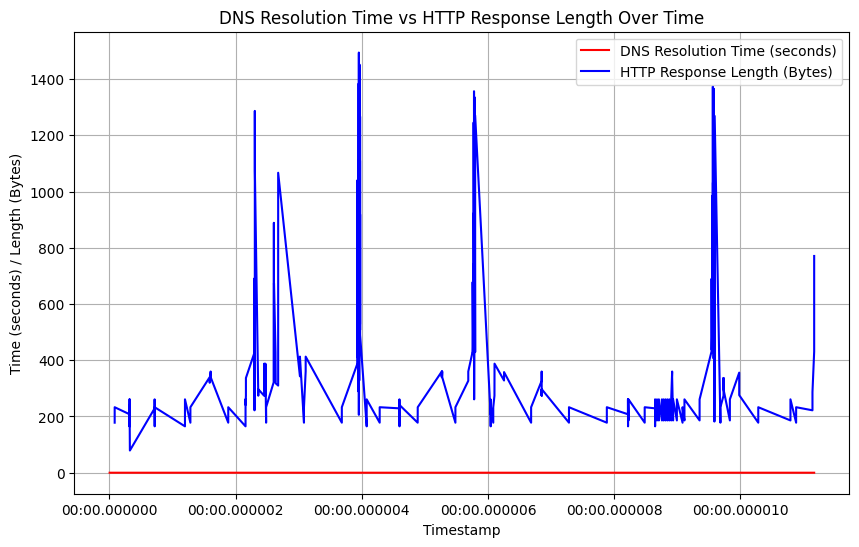

In [30]:
# Visualization 2: Line Plot of DNS Resolution Times and HTTP Response Length
plt.figure(figsize=(10, 6))
plt.plot(dns_pairs['Time_query'], dns_pairs['resolution_time'], label='DNS Resolution Time (seconds)', color='red')
plt.plot(http_df['Time'], http_df['Length'], label='HTTP Response Length (Bytes)', color='blue')
plt.xlabel("Timestamp")
plt.ylabel("Time (seconds) / Length (Bytes)")
plt.legend()
plt.title("DNS Resolution Time vs HTTP Response Length Over Time")
plt.grid()
plt.show()

***Line Plot of DNS Resolution Times and HTTP Response Length Over Time:***
* This plot visualizes DNS resolution time alongside HTTP response lengths to help identify any relationship between DNS delays and HTTP response size fluctuations.

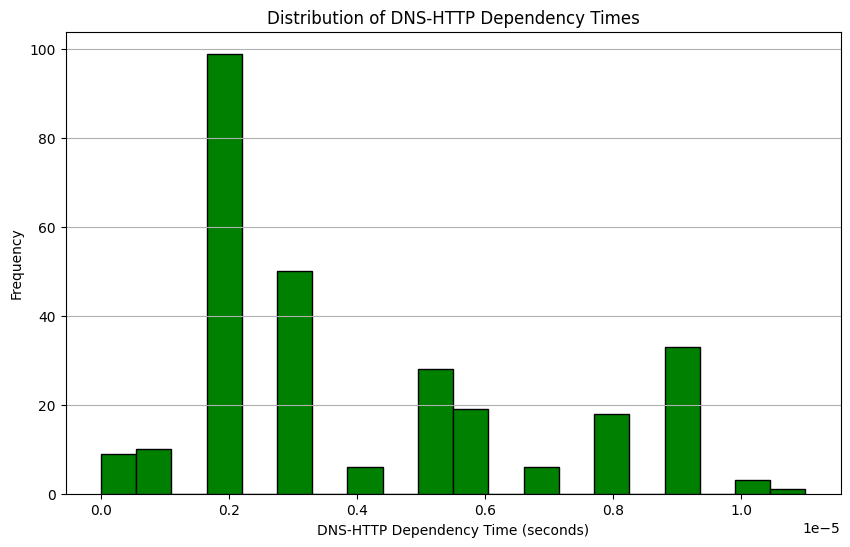

In [31]:
# Visualization 3: Histogram of DNS-HTTP Dependency Times
plt.figure(figsize=(10, 6))
http_requests['dns_http_dependency'].dropna().plot(kind='hist', bins=20, color='green', edgecolor='black')
plt.xlabel("DNS-HTTP Dependency Time (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of DNS-HTTP Dependency Times")
plt.grid(axis='y')
plt.show()

***Histogram of DNS-HTTP Dependency Times:***
* This histogram highlights the frequency of various DNS-HTTP dependency times, showing how often different delays occur, which can reveal common bottlenecks.

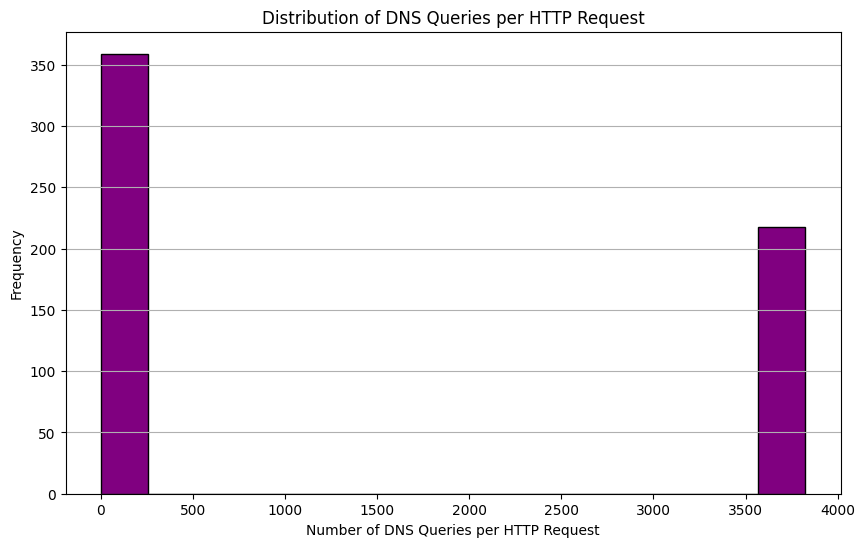

In [32]:
# Visualization 4: Histogram of DNS Queries per HTTP Request
# Count DNS queries per unique HTTP request (using destination IP as identifier)
dns_query_count = dns_pairs.groupby('Destination').size().reset_index(name='dns_query_count')

# Merge with HTTP requests to show DNS query count per HTTP request destination
http_requests = http_requests.merge(dns_query_count, how='left', on='Destination')
http_requests['dns_query_count'] = http_requests['dns_query_count'].fillna(0)

# Plot: Histogram of DNS Queries per HTTP Request
plt.figure(figsize=(10, 6))
http_requests['dns_query_count'].plot(kind='hist', bins=15, color='purple', edgecolor='black')
plt.xlabel("Number of DNS Queries per HTTP Request")
plt.ylabel("Frequency")
plt.title("Distribution of DNS Queries per HTTP Request")
plt.grid(axis='y')
plt.show()


***Number of DNS Queries per HTTP Request***
* This metric highlights cases where multiple DNS queries precede a single HTTP request, potentially indicating inefficiencies or caching issues.

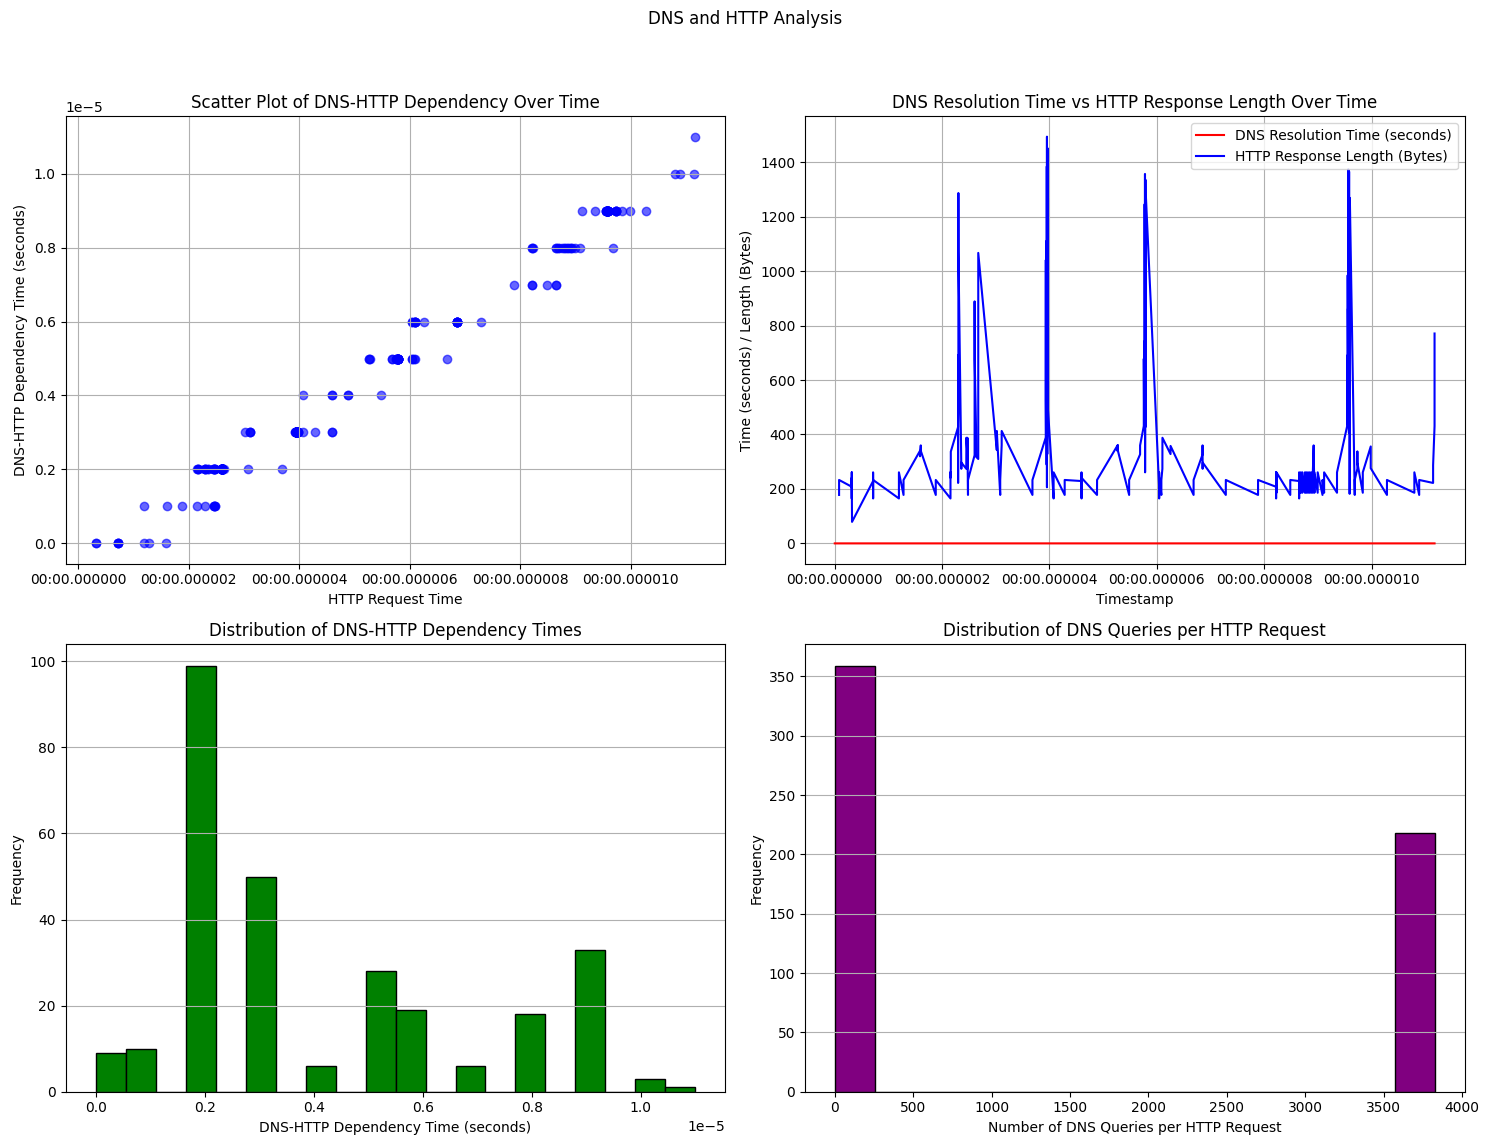

In [33]:
# Create subplots for all graphs with annotations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('DNS and HTTP Analysis')

# Scatter Plot of DNS-HTTP Dependency Over Time
axes[0, 0].scatter(http_requests['Time'], http_requests['dns_http_dependency'], alpha=0.6, color='blue')
axes[0, 0].set_xlabel('HTTP Request Time')
axes[0, 0].set_ylabel('DNS-HTTP Dependency Time (seconds)')
axes[0, 0].set_title('Scatter Plot of DNS-HTTP Dependency Over Time')
axes[0, 0].grid(True)


# Line Plot of DNS Resolution Times and HTTP Response Length
axes[0, 1].plot(dns_pairs['Time_query'], dns_pairs['resolution_time'], label='DNS Resolution Time (seconds)', color='red')
axes[0, 1].plot(http_df['Time'], http_df['Length'], label='HTTP Response Length (Bytes)', color='blue')
axes[0, 1].set_xlabel("Timestamp")
axes[0, 1].set_ylabel("Time (seconds) / Length (Bytes)")
axes[0, 1].legend()
axes[0, 1].set_title("DNS Resolution Time vs HTTP Response Length Over Time")
axes[0, 1].grid()


# Histogram of DNS-HTTP Dependency Times
http_requests['dns_http_dependency'].dropna().plot(kind='hist', bins=20, color='green', edgecolor='black', ax=axes[1, 0])
axes[1, 0].set_xlabel("DNS-HTTP Dependency Time (seconds)")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].set_title("Distribution of DNS-HTTP Dependency Times")
axes[1, 0].grid(axis='y')


# Plot: Histogram of DNS Queries per HTTP Request
http_requests['dns_query_count'].plot(kind='hist', bins=15, color='purple', edgecolor='black', ax=axes[1, 1])
axes[1, 1].set_xlabel("Number of DNS Queries per HTTP Request")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].set_title("Distribution of DNS Queries per HTTP Request")
axes[1, 1].grid(axis='y')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to include the main title
plt.show()

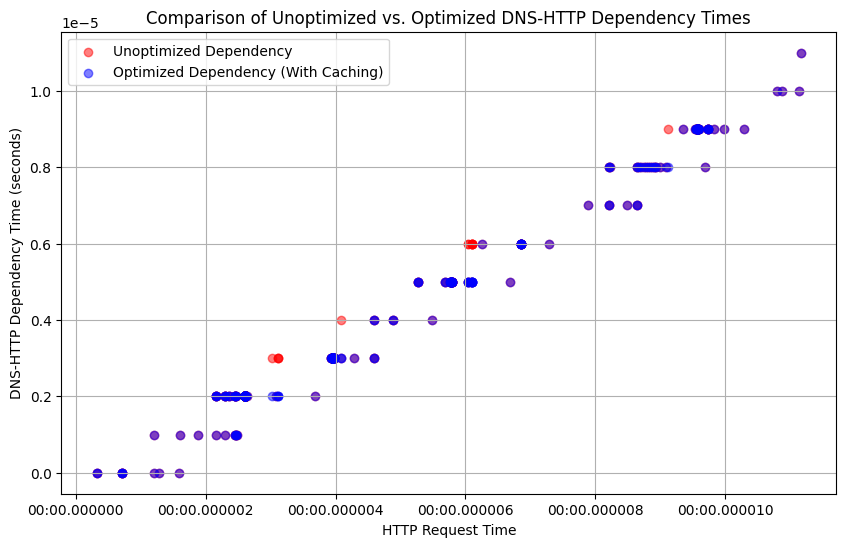

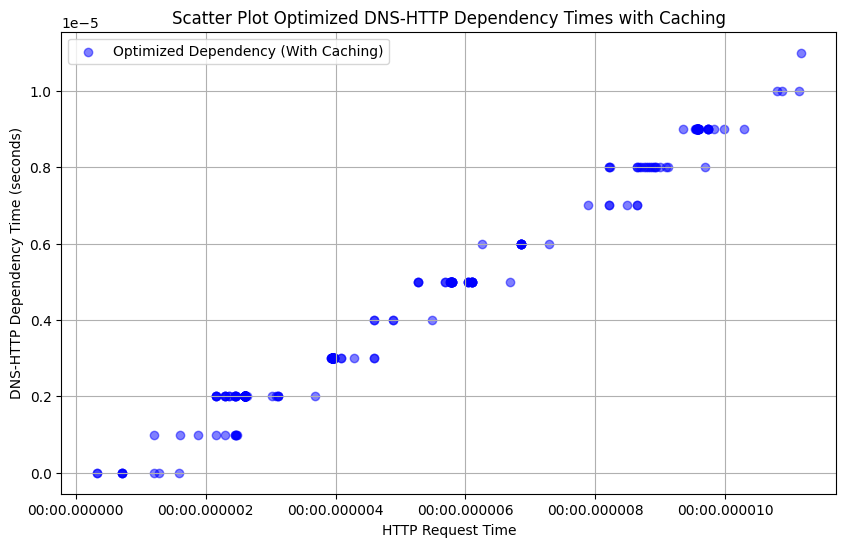

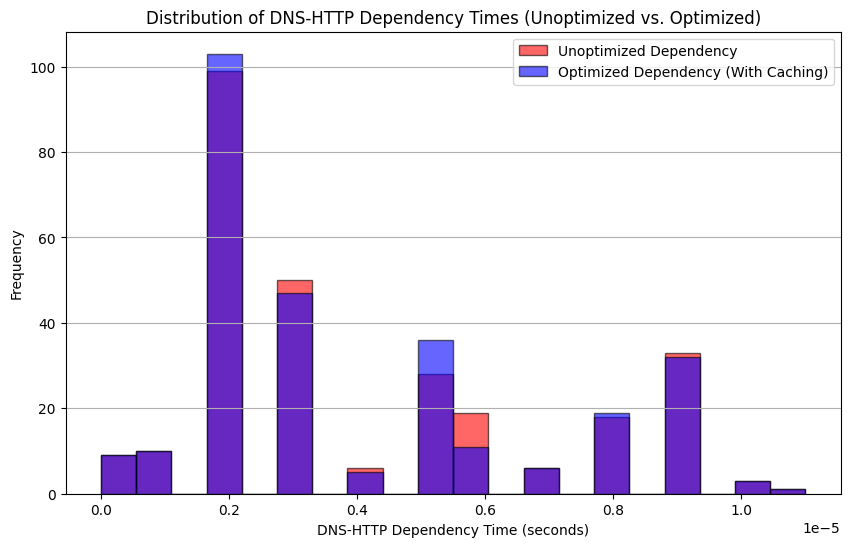

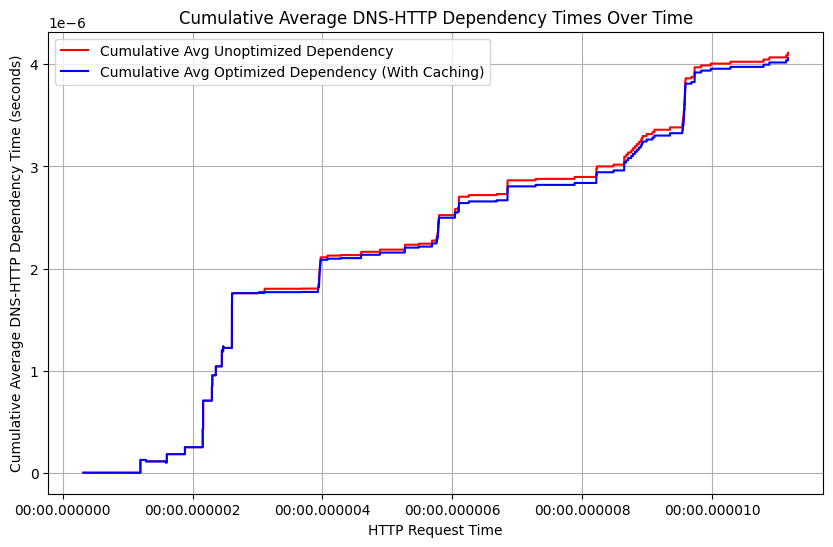

In [34]:
# Plot both unoptimized and optimized dependencies
plt.figure(figsize=(10, 6))
plt.scatter(http_requests['Time'], http_requests['dns_http_dependency'], alpha=0.5, color='red', label="Unoptimized Dependency")
plt.scatter(http_requests['Time'], http_requests['dns_http_dependency_optimized'], alpha=0.5, color='blue', label="Optimized Dependency (With Caching)")
plt.xlabel('HTTP Request Time')
plt.ylabel('DNS-HTTP Dependency Time (seconds)')
plt.title('Comparison of Unoptimized vs. Optimized DNS-HTTP Dependency Times')
plt.legend()
plt.grid()
plt.show()

# Plot both unoptimized and optimized dependencies
plt.figure(figsize=(10, 6))
# plt.scatter(http_requests['Time'], http_requests['dns_http_dependency'], alpha=0.5, color='red', label="Unoptimized Dependency")
plt.scatter(http_requests['Time'], http_requests['dns_http_dependency_optimized'], alpha=0.5, color='blue', label="Optimized Dependency (With Caching)")
plt.xlabel('HTTP Request Time')
plt.ylabel('DNS-HTTP Dependency Time (seconds)')
plt.title('Scatter Plot Optimized DNS-HTTP Dependency Times with Caching')
plt.legend()
plt.grid()
plt.show()

# Histogram for Unoptimized Dependency Times
plt.figure(figsize=(10, 6))
http_requests['dns_http_dependency'].dropna().plot(kind='hist', bins=20, color='red', alpha=0.6, edgecolor='black', label="Unoptimized Dependency")
http_requests['dns_http_dependency_optimized'].dropna().plot(kind='hist', bins=20, color='blue', alpha=0.6, edgecolor='black', label="Optimized Dependency (With Caching)")
plt.xlabel("DNS-HTTP Dependency Time (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of DNS-HTTP Dependency Times (Unoptimized vs. Optimized)")
plt.legend()
plt.grid(axis='y')
plt.show()

# Calculate cumulative average dependency times
http_requests['cumulative_avg_unoptimized'] = http_requests['dns_http_dependency'].expanding().mean()
http_requests['cumulative_avg_optimized'] = http_requests['dns_http_dependency_optimized'].expanding().mean()

# Line plot of cumulative averages
plt.figure(figsize=(10, 6))
plt.plot(http_requests['Time'], http_requests['cumulative_avg_unoptimized'], color='red', label="Cumulative Avg Unoptimized Dependency")
plt.plot(http_requests['Time'], http_requests['cumulative_avg_optimized'], color='blue', label="Cumulative Avg Optimized Dependency (With Caching)")
plt.xlabel('HTTP Request Time')
plt.ylabel('Cumulative Average DNS-HTTP Dependency Time (seconds)')
plt.title('Cumulative Average DNS-HTTP Dependency Times Over Time')
plt.legend()
plt.grid()
plt.show()